In [1]:
!pip install torchinfo
!pip install datasets
!pip install hexbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import pandas as pd
import math

from PIL import Image
from torch import nn
from torch import optim
from torchinfo import summary
from datasets import load_dataset
from torchvision import transforms, models
from argparse import ArgumentParser
from torch.utils.data import DataLoader
from torch.nn.functional import normalize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from hexbytes import HexBytes
from tqdm import tqdm

In [3]:
train_ds = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='train', ignore_verifications=True)
val_ds = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='validation', ignore_verifications=True)


/usr/local/lib/python3.10/dist-packages/datasets/load.py:2491: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for mwritescode/slither-audited-smart-contracts contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mwritescode/slither-audited-smart-contracts
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/79641 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10861 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2491: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for mwritescode/slither-audited-smart-contracts contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mwritescode/slither-audited-smart-contracts
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
train_ds = train_ds.filter(lambda elem: elem['bytecode'] != '0x')
val_ds = val_ds.filter(lambda elem: elem['bytecode'] != '0x')

Filter:   0%|          | 0/79641 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10861 [00:00<?, ? examples/s]

In [5]:
SAFE_IDX = 4 # the index of safe smart contract

def __get_RGB_image(bytecode):
    image = np.frombuffer(bytecode, dtype=np.uint8)
    length = int(math.ceil(len(image)/3))
    image = np.pad(image, pad_width=(0, length*3 - len(image)))
    image = image.reshape((-1, 3))
    sqrt_len = int(math.ceil(math.sqrt(image.shape[0])))
    image = np.pad(image,  pad_width=((0, sqrt_len**2 - image.shape[0]),(0,0)))
    image = image.reshape((sqrt_len, sqrt_len, 3))
    image = Image.fromarray(image)
    return image

def __get_one_hot_encoded_label(label):
    one_hot = np.zeros(5)
    for elem in label:
        if elem < SAFE_IDX:
            one_hot[elem] = 1
        elif elem > SAFE_IDX:
            one_hot[elem-1] = 1
    return one_hot

def generate_image_and_label(example):
    code = HexBytes(example['bytecode'])
    example['image'] = __get_RGB_image(code)
    example['label'] = __get_one_hot_encoded_label(example['slither'])
    return example

In [6]:
map_func = generate_image_and_label
train_ds = train_ds.map(map_func, remove_columns=['address', 'source_code', 'bytecode', 'slither'])
val_ds = val_ds.map(map_func, remove_columns=['address', 'source_code', 'bytecode', 'slither'])

Map:   0%|          | 0/79414 [00:00<?, ? examples/s]

Map:   0%|          | 0/10831 [00:00<?, ? examples/s]

In [7]:
IMG_SIZE = 224

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

img_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [8]:
def img_label_to_tensor(examples):
    examples['image'] = [img_transform(elem) for elem in examples['image']]
    examples['label'] = torch.tensor(examples['label'])
    return examples

In [9]:
train_ds.set_transform(img_label_to_tensor)
val_ds.set_transform(img_label_to_tensor)

In [10]:
batch_size = 32

loader_train = DataLoader(train_ds,
                    batch_size=batch_size,
                    drop_last=True,
                    shuffle=True)
loader_val = DataLoader(val_ds,
                    batch_size=batch_size,
                    drop_last=True,
                    shuffle=False)

In [11]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, inputs):
        return self.resnet(inputs)

    def get_layer_groups(self):
        linear_layers = [elem[1] for elem in filter(lambda param_tuple: 'fc' in param_tuple[0], self.resnet.named_parameters())]
        other_layers = [elem[1] for elem in filter(lambda param_tuple: 'fc' not in param_tuple[0], self.resnet.named_parameters())]
        param_groups = {
            'classifier': linear_layers,
            'feature_extractor': other_layers
        }
        return param_groups

In [12]:
num_cls = 5
model_name = 'resnet'
device = torch.device('cuda')

model = ResNetModel(num_classes=num_cls)
model = model.to(device)

TRAIN_FROM_SCRATCH = False
if not TRAIN_FROM_SCRATCH:
    param_groups = model.get_layer_groups()
    for param in param_groups['feature_extractor'][:-6]:
        param.requires_grad = False
summary(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 63.1MB/s]


Layer (type:depth-idx)                        Param #
ResNetModel                                   --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (75,008)
│    │    └─Bottleneck: 3-2                   (70,400)
│    │    └─Bottleneck: 3-3                   (70,400)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (379,392)
│    │    └─Bottleneck: 3-5                   (280,064)
│    │    └─Bottleneck: 3-6                   (280,064)
│    │    └─Bottleneck: 3-7                   (280,064)
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   (1,512,448)
│    │    └─Bottleneck: 3-9                   (1,1

In [13]:
optimizer = optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    nesterov=True)
criterion = nn.BCEWithLogitsLoss()

In [14]:
def initialize_logs_dict(loader_train, loader_val):
    metrics = {'acc': accuracy_score, 'f1_score': f1_score, 'precision': precision_score, 'recall': recall_score}
    logs = {
        'epoch_num': 0,
        'train_batches_per_epoch': len(loader_train),
        'val_batches_per_epoch': len(loader_val) if loader_val is not None else None,
        'train': {'loss': 0.0, 'predictions': [], 'labels': [], 'batch_idx': 0},
        'val': {'loss': 0.0, 'predictions': [], 'labels': [], 'batch_idx': 0},
        'metrics': {'train_acc': 0.0} | {'val_' + metric: 0.0 for metric in metrics.keys()}
    }
    return logs

def run_epoch(model, criterion, optimizer, data_loader, device, mode, logs):
    model.train() if mode == 'train' else model.eval()
    metrics = None
    if mode == 'val':
        metrics = {'acc': accuracy_score, 'f1_score': f1_score, 'precision': precision_score, 'recall': recall_score}
    else:
        metrics = {'acc': accuracy_score}

    total_loss = 0.0
    running_metrics = {metric: 0.0 for metric in metrics.keys()}
    pbar = tqdm(data_loader, desc=f'{mode.capitalize()}ing...')

    for data in pbar:
        images, labels = data['image'].to(device), data['label'].to(device)

        with torch.set_grad_enabled(mode == 'train'):
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs >= 0.0).float()
            logs[mode]['predictions'] += preds.tolist()
            logs[mode]['labels'] += labels.tolist()
            logs[f'{mode}_loss'] = total_loss / (logs[mode]['batch_idx'] + 1)

            for metric_name, metric_func in metrics.items():
                if metric_name == 'acc':
                    running_metrics[metric_name] += metric_func(labels.tolist(), preds.tolist())
                else:
                    running_metrics[metric_name] += metric_func(labels.tolist(), preds.tolist(), average='micro')
                logs['metrics'][mode + '_' + metric_name] = running_metrics[metric_name] / (logs[mode]['batch_idx'] + 1)

            logs[mode]['batch_idx'] += 1
            pbar.set_postfix({'loss': logs[f'{mode}_loss'], **{metric_name: logs['metrics'][mode + '_' + metric_name] for metric_name in metrics.keys()}})

            if mode == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

def main_training_loop(model, criterion, optimizer, loader_train, loader_val, device, epochs):
    history = {}
    # combine logs, so it will be easier to create graphs
    for epoch in range(epochs):
        print(f'Epoch {epoch}:')
        logs = initialize_logs_dict(loader_train, loader_val)
        logs['epoch_num'] = epoch

        run_epoch(model, criterion, optimizer, loader_train, device, 'train', logs)
        run_epoch(model, criterion, optimizer, loader_val, device, 'val', logs)

        print('train_loss: {:.4f} | val_loss: {:.4f} |'.format(logs['train_loss'], logs['val_loss']), end=' ')
        print(" | ".join(['{}: {:.4f}'.format(metric_name, metric_val) for metric_name, metric_val in logs['metrics'].items()]), end='\n\n')
        history[epoch] = logs
    return history


In [15]:
epochs = 12
history = main_training_loop(model, criterion, optimizer, loader_train, loader_val, device, epochs)

Epoch 0:


Valing...: 100%|██████████| 338/338 [00:54<00:00,  6.24it/s, loss=0.426, acc=0.441, f1_score=0.57, precision=0.717, recall=0.48]


train_loss: 0.4549 | val_loss: 0.4263 | train_acc: 0.4080 | val_acc: 0.4411 | val_f1_score: 0.5697 | val_precision: 0.7166 | val_recall: 0.4805

Epoch 1:


Valing...: 100%|██████████| 338/338 [00:53<00:00,  6.27it/s, loss=0.408, acc=0.469, f1_score=0.592, precision=0.746, recall=0.498]


train_loss: 0.4234 | val_loss: 0.4077 | train_acc: 0.4473 | val_acc: 0.4691 | val_f1_score: 0.5921 | val_precision: 0.7460 | val_recall: 0.4983

Epoch 2:


Valing...: 100%|██████████| 338/338 [00:54<00:00,  6.22it/s, loss=0.396, acc=0.48, f1_score=0.621, precision=0.732, recall=0.546]


train_loss: 0.4091 | val_loss: 0.3960 | train_acc: 0.4666 | val_acc: 0.4805 | val_f1_score: 0.6209 | val_precision: 0.7320 | val_recall: 0.5464

Epoch 3:


Valing...: 100%|██████████| 338/338 [00:53<00:00,  6.27it/s, loss=0.387, acc=0.495, f1_score=0.635, precision=0.741, recall=0.563]


train_loss: 0.3991 | val_loss: 0.3871 | train_acc: 0.4786 | val_acc: 0.4945 | val_f1_score: 0.6349 | val_precision: 0.7414 | val_recall: 0.5625

Epoch 4:


Valing...: 100%|██████████| 338/338 [00:53<00:00,  6.33it/s, loss=0.38, acc=0.506, f1_score=0.632, precision=0.767, recall=0.545]


train_loss: 0.3891 | val_loss: 0.3804 | train_acc: 0.4916 | val_acc: 0.5059 | val_f1_score: 0.6321 | val_precision: 0.7666 | val_recall: 0.5447

Epoch 5:


Valing...: 100%|██████████| 338/338 [00:53<00:00,  6.37it/s, loss=0.374, acc=0.513, f1_score=0.642, precision=0.771, recall=0.557]


train_loss: 0.3816 | val_loss: 0.3737 | train_acc: 0.4979 | val_acc: 0.5129 | val_f1_score: 0.6420 | val_precision: 0.7707 | val_recall: 0.5571

Epoch 6:


Valing...: 100%|██████████| 338/338 [00:53<00:00,  6.33it/s, loss=0.367, acc=0.52, f1_score=0.66, precision=0.759, recall=0.591]


train_loss: 0.3742 | val_loss: 0.3665 | train_acc: 0.5056 | val_acc: 0.5196 | val_f1_score: 0.6596 | val_precision: 0.7588 | val_recall: 0.5911

Epoch 7:


Valing...: 100%|██████████| 338/338 [00:52<00:00,  6.41it/s, loss=0.361, acc=0.527, f1_score=0.667, precision=0.763, recall=0.6]


train_loss: 0.3668 | val_loss: 0.3614 | train_acc: 0.5144 | val_acc: 0.5265 | val_f1_score: 0.6673 | val_precision: 0.7634 | val_recall: 0.5998

Epoch 8:


Valing...: 100%|██████████| 338/338 [00:52<00:00,  6.39it/s, loss=0.357, acc=0.531, f1_score=0.669, precision=0.767, recall=0.601]


train_loss: 0.3614 | val_loss: 0.3571 | train_acc: 0.5212 | val_acc: 0.5308 | val_f1_score: 0.6695 | val_precision: 0.7669 | val_recall: 0.6009

Epoch 9:


Valing...: 100%|██████████| 338/338 [00:52<00:00,  6.42it/s, loss=0.352, acc=0.538, f1_score=0.671, precision=0.776, recall=0.599]


train_loss: 0.3540 | val_loss: 0.3522 | train_acc: 0.5285 | val_acc: 0.5380 | val_f1_score: 0.6712 | val_precision: 0.7757 | val_recall: 0.5987

Epoch 10:


Valing...: 100%|██████████| 338/338 [00:52<00:00,  6.40it/s, loss=0.351, acc=0.542, f1_score=0.684, precision=0.755, recall=0.632]


train_loss: 0.3478 | val_loss: 0.3510 | train_acc: 0.5358 | val_acc: 0.5420 | val_f1_score: 0.6841 | val_precision: 0.7550 | val_recall: 0.6325

Epoch 11:


Valing...: 100%|██████████| 338/338 [00:52<00:00,  6.41it/s, loss=0.347, acc=0.542, f1_score=0.68, precision=0.766, recall=0.618]

train_loss: 0.3419 | val_loss: 0.3467 | train_acc: 0.5428 | val_acc: 0.5417 | val_f1_score: 0.6800 | val_precision: 0.7664 | val_recall: 0.6180



In [16]:
torch.save(model.state_dict(), 'model3.pt')

In [17]:
# Create a new modified dictionary without keys "labels" and "prediction"
metrics_history = {key: {k: v for k, v in inner_dict.items() if k not in ['train', 'val']} for key, inner_dict in history.items()}

In [18]:
metrics_history

{0: {'epoch_num': 0,
  'train_batches_per_epoch': 2481,
  'val_batches_per_epoch': 338,
  'metrics': {'train_acc': 0.40798821039903266,
   'val_acc': 0.4411057692307692,
   'val_f1_score': 0.5697277497325017,
   'val_precision': 0.7166387082891565,
   'val_recall': 0.48047894658483037},
  'train_loss': 0.45488084697137193,
  'val_loss': 0.42631745585323083},
 1: {'epoch_num': 1,
  'train_batches_per_epoch': 2481,
  'val_batches_per_epoch': 338,
  'metrics': {'train_acc': 0.447312071745264,
   'val_acc': 0.4691198224852071,
   'val_f1_score': 0.5920580373269618,
   'val_precision': 0.7460260530940444,
   'val_recall': 0.4982706471564304},
  'train_loss': 0.42341691910235546,
  'val_loss': 0.40769087223435296},
 2: {'epoch_num': 2,
  'train_batches_per_epoch': 2481,
  'val_batches_per_epoch': 338,
  'metrics': {'train_acc': 0.46663391777509067,
   'val_acc': 0.48049186390532544,
   'val_f1_score': 0.6209444816160199,
   'val_precision': 0.7320203433578347,
   'val_recall': 0.546419084386

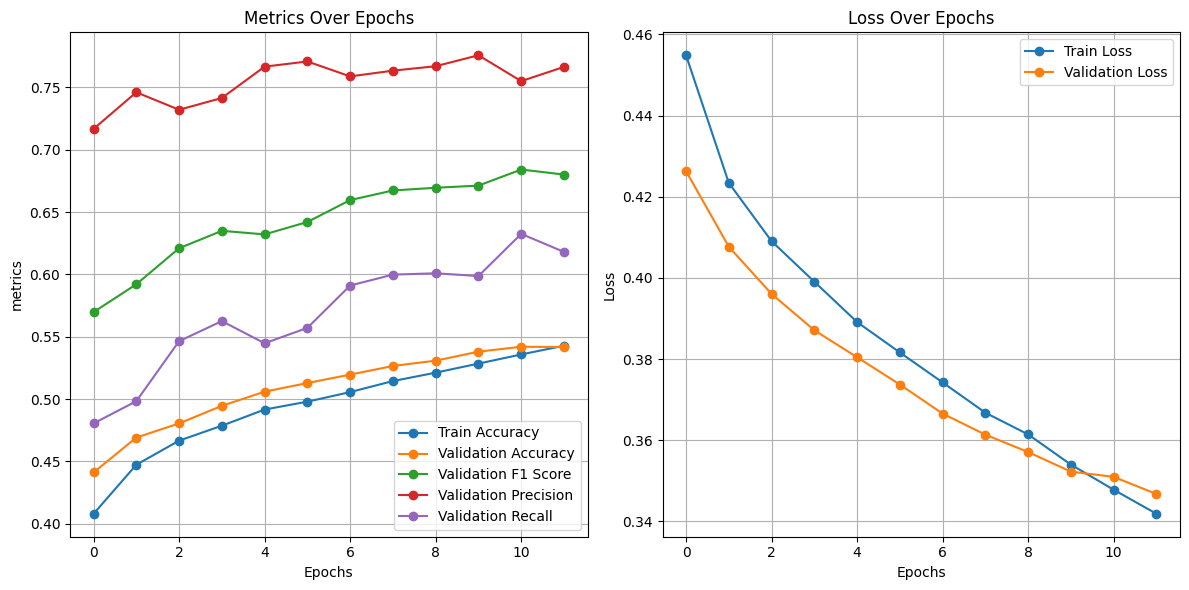

In [19]:
import matplotlib.pyplot as plt

data = metrics_history

epochs = [entry['epoch_num'] for entry in data.values()]
train_acc = [entry['metrics']['train_acc'] for entry in data.values()]
val_acc = [entry['metrics']['val_acc'] for entry in data.values()]
val_f1_score = [entry['metrics']['val_f1_score'] for entry in data.values()]
val_precision = [entry['metrics']['val_precision'] for entry in data.values()]
val_recall = [entry['metrics']['val_recall'] for entry in data.values()]

train_loss = [entry['train_loss']  for entry in data.values()]
val_loss = [entry['val_loss'] for entry in data.values()]

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.plot(epochs, val_f1_score, label='Validation F1 Score', marker='o')
plt.plot(epochs, val_precision, label='Validation Precision', marker='o')
plt.plot(epochs, val_recall, label='Validation Recall', marker='o')
plt.title('Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('metrics')
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()